I want to estimate sigma we use to perturb bands in l2gen for our MC uncertainty
simulation. For this purpose, I want to estimate shot noise (N) using an interpolation table - table 28 of swf pre-launch acceptance report (vol 22) that relates L_typical to SNR. The steps implemented below are:

1. Get data and remove discard flagged pixels
    - this brings most of the data within interpolation range (see below)
2. Theshhold the rest of the data so that they are all within interpolation range  
3. Do a nearest neighbor(?) interpolation to get an snr reading for each pixel
4. Calculate shot noise, N = lt/snr_lt.
5. Calculate mean of shot noise, N_mean.
6. Compare to previous estimate of 0.003 used in MC simulation.
7. Decide => Should we do it again?

Signal-to-noise ratio is also defined for random variables in one of two ways.

* X=s+N , where s , the signal, is a constant and N is a random variable having an expected value equal to zero. The SNR equals s^2/σ^2_N , with σ^2_N the variance of N .
* X=S+N , where both S and N are random variables.

A random variable's power equals its mean-squared value: the signal power thus equals E[S^2]. Usually, the noise has zero mean, which makes its power equal to its variance. Thus, the SNR equals E[S^2]/σ^2_N .

In [1]:
# IMPORTS
import netCDF4 as nc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import pickle

In [2]:
# GRAPHIC SETUP
%matplotlib inline 

In [3]:
# MAKING LUT, which is effectively a collection of LUT arrays
# TO DO THIS, LOAD excel data into PANDAS DATAFRAME
data = '/disk01/home/ekarakoy/UNCERTAINTIES/SNR/UNC_SWF_PreL_Vol22.xlsx'
swf_unc=pd.ExcelFile(data)
# The file contains two sheets. one details the lower (purple - green) 4 bands.
# This data comes from table 28 and relates L_typical to SNR.
# The 2nd sheet comes from table 29, has a different progression (dLtyp)
# (that's why I didn't merge the data) and addresses the higher (green/yellow - NIR) 4 bands.
# These data are now in their corresponding PANDAS DATAFRAMES; bands1_4 and bands5_8
bands1_4 = swf_unc.parse(sheetname=swf_unc.sheet_names[0])
bands5_8 = swf_unc.parse(sheetname=swf_unc.sheet_names[1])

In [4]:
# SOME FUNCTIONS

# I selected a deg.4 polynomial by visual inspection; didn't know any better back then.
# Shouldn't be a problem since the model curve is monotonic and smooth and any data
# we encounter is, as far as I've tested, in the model input range.
def ApplyPolyFit(cf,lt,deg=4):
    y = 0
    for i in range(deg):
        y += cf[i] * (lt** (deg - i))
    y += cf[deg]
    return y

def MakeL2GenMask():
    fail = 2**0 + 2**1+ 2**3 + 2**4 + 2**6+ 2**8+ 2**9 + 2**12 + (
        2**15) + 2**20+ 2**24 + 2**25 +2**30
    return np.ma.make_mask((l2flagsArr&fail))

In [5]:
# Take a look 
bands1_4.head()

,Radiance,Counts_412,SNR_412,Counts_443,SNR_443,Counts_490,SNR_490,Counts_510,SNR_510
0,11.3,793,1133,-1,-1,-1,-1,-1,-1
1,11.1,779,1121,-1,-1,-1,-1,-1,-1
2,10.9,765,1109,-1,-1,-1,-1,-1,-1
3,10.7,751,1096,787,1271,-1,-1,-1,-1
4,10.5,737,1083,772,1256,-1,-1,-1,-1


In [6]:
bands5_8.head()

,Radiance,Counts_555,SNR_555,Counts_670,SNR_670,Counts_765,SNR_765,Counts_865,SNR_865
0,5.75,764,1237,-1,-1,-1,-1,-1,-1
1,5.65,751,1223,-1,-1,-1,-1,-1,-1
2,5.55,737,1210,-1,-1,-1,-1,-1,-1
3,5.45,724,1197,-1,-1,-1,-1,-1,-1
4,5.35,711,1183,-1,-1,-1,-1,-1,-1


In [8]:
# 
bands1_4.to_csv('SNR_1_4.csv',columns=['Radiance','SNR_412','SNR_443',
                                       'SNR_490','SNR_510'],index=False)
bands5_8.to_csv('SNR_5_8.csv',columns=['Radiance','SNR_555','SNR_670',
                                       'SNR_765','SNR_865'],index=False)

# assign radiance data and convert units from mW/cm2/um/sr to 
# W/m2/um/sr

radiance_412_510 =np.array(bands1_4['Radiance'])
radiance_555_865 = np.array(bands5_8['Radiance'])
# load snr data
snr_412 = np.array(bands1_4['SNR_412'])
snr_443 = np.array(bands1_4['SNR_443'])
snr_490 = np.array(bands1_4['SNR_490'])
snr_510 = np.array(bands1_4['SNR_510'])
snr_555 = np.array(bands5_8['SNR_555'])
snr_670 = np.array(bands5_8['SNR_670'])
snr_765 = np.array(bands5_8['SNR_765'])
snr_865 = np.array(bands5_8['SNR_865'])                   

In [8]:
#BUILD SNR AND LT dictionaries
bands=['412','443','490','510','555','670','765','865']
ltdict = dict.fromkeys(bands)
snrdict=dict.fromkeys(bands)
ltdict['412'] = (radiance_412_510[snr_412>0])
snrdict['412'] = snr_412[snr_412>0]
ltdict['443'] = (radiance_412_510[snr_443>0])
snrdict['443'] = snr_443[snr_443>0]
ltdict['490'] = (radiance_412_510[snr_490>0])
snrdict['490'] = snr_490[snr_490>0]
ltdict['510'] = (radiance_412_510[snr_510>0])
snrdict['510'] = snr_510[snr_510>0]
ltdict['555'] = (radiance_555_865[snr_555>0])
snrdict['555'] = snr_555[snr_555>0]
ltdict['670'] = (radiance_555_865[snr_670>0])
snrdict['670']= snr_670[snr_670>0]
ltdict['765'] = (radiance_555_865[snr_765>0])
snrdict['765'] = snr_765[snr_765>0]
ltdict['865'] = (radiance_555_865[snr_865>0])
snrdict['865'] = snr_865[snr_865>0]

In [9]:
deg=4
coefdict = dict.fromkeys(bands)
for band in bands:
    coefdict[band] = np.polyfit(ltdict[band],snrdict[band],deg=deg)
coefdict

{'412': array([ -8.28726301e-03,   3.85425664e-01,  -9.10776926e+00,
          1.65881862e+02,   4.54351582e-01]),
 '443': array([ -1.21871258e-02,   5.21579320e-01,  -1.14574109e+01,
          1.96509056e+02,   4.18921861e-01]),
 '490': array([ -2.99068165e-02,   1.05225457e+00,  -1.90591166e+01,
          2.66343986e+02,   6.67187489e-01]),
 '510': array([ -5.68939986e-02,   1.67950509e+00,  -2.56915149e+01,
          3.05832773e+02,   9.34468454e-01]),
 '555': array([ -1.31635902e-01,   3.09617393e+00,  -3.73473556e+01,
          3.52394751e+02,   3.54105899e-01]),
 '670': array([ -8.65458303e-01,   1.18857306e+01,  -8.37771886e+01,
          4.64496430e+02,   4.14633422e-02]),
 '765': array([ -4.96827099e+00,   4.50239057e+01,  -2.10425126e+02,
          7.75862055e+02,   5.18893137e-02]),
 '865': array([ -1.30487418e+01,   9.35407901e+01,  -3.40988182e+02,
          9.43414239e+02,   7.84956550e-01])}

In [10]:
# Quick confirmation that the polynomial fit is appropriate for l2gen-internal
modlSnrDict=dict.fromkeys(bands)
for band in bands:
    modlSnrDict[band] = ApplyPolyFit(coefdict[band],ltdict[band],deg)

In [12]:
# gather data into single summary list
snrWbkEss = [ltdict,snrdict,modlSnrDict]
# serialize and dump summary list into a binary file for later use
pickle.dump(snrWbkEss,open("SNRWORKBOOKESSENTIALS.p","wb"))

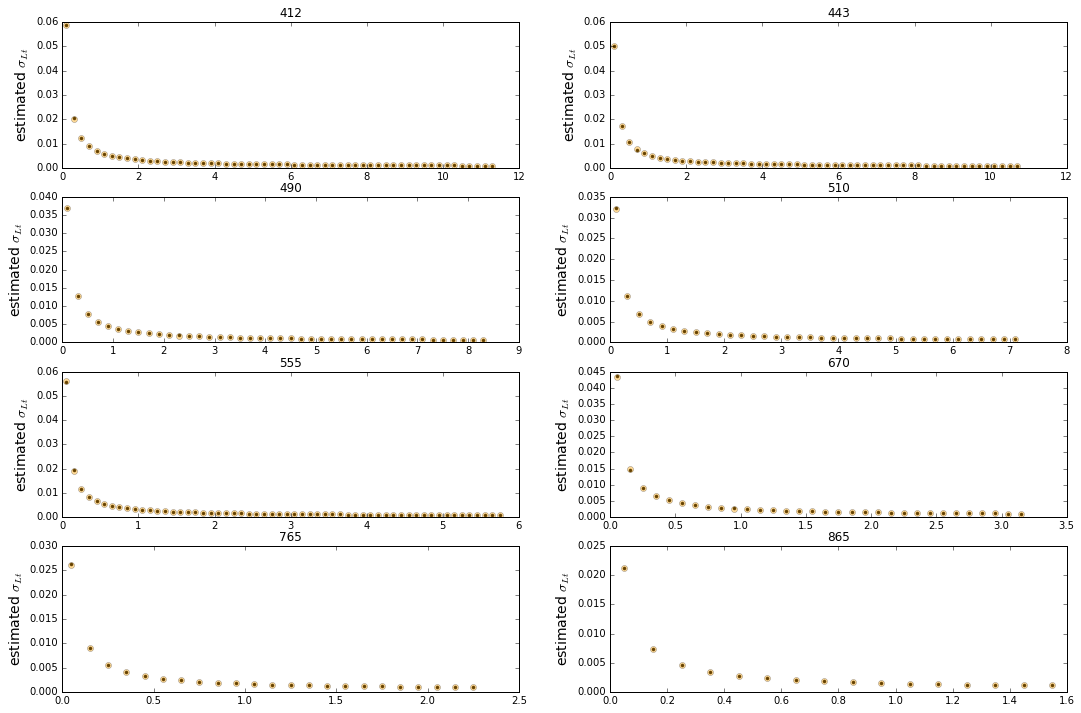

In [14]:
# PLOT COMPARISON BETWEEN sigma calculated from snr table (plot marker is '.') 
# and sigma calculated from snr model (plot marker is 'o')
plt.figure(figsize=(18,12))
plt.subplot(421)
band='412'
plt.title(band)
plt.ylabel('estimated $\sigma_{Lt}$',fontsize=14)
plt.plot(ltdict[band],1/snrdict[band],marker='.',ls='',color='k')
plt.plot(ltdict[band],1/modlSnrDict[band],marker = 'o',ls='',color='orange',alpha=0.4)
plt.subplot(422)
band='443'
plt.title(band)
plt.ylabel('estimated $\sigma_{Lt}$',fontsize=14)
plt.plot(ltdict[band],1/snrdict[band],marker='.',ls='',color='k')
plt.plot(ltdict[band],1/modlSnrDict[band],marker = 'o',ls='',color='orange',alpha=0.4)
plt.subplot(423)
band='490'
plt.title(band)
plt.ylabel('estimated $\sigma_{Lt}$',fontsize=14)
plt.plot(ltdict[band],1/snrdict[band],marker='.',ls='',color='k')
plt.plot(ltdict[band],1/modlSnrDict[band],marker = 'o',ls='',color='orange',alpha=0.4)
plt.subplot(424)
band='510'
plt.title(band)
plt.ylabel('estimated $\sigma_{Lt}$',fontsize=14)
plt.plot(ltdict[band],1/snrdict[band],marker='.',ls='',color='k')
plt.plot(ltdict[band],1/modlSnrDict[band],marker = 'o',ls='',color='orange',alpha=0.4)
plt.subplot(425)
band='555'
plt.title(band)
plt.ylabel('estimated $\sigma_{Lt}$',fontsize=14)
plt.plot(ltdict[band],1/snrdict[band],marker='.',ls='',color='k')
plt.plot(ltdict[band],1/modlSnrDict[band],marker = 'o',ls='',color='orange',alpha=0.4)
plt.subplot(426)
band='670'
plt.title(band)
plt.ylabel('estimated $\sigma_{Lt}$',fontsize=14)
plt.plot(ltdict[band],1/snrdict[band],marker='.',ls='',color='k')
plt.plot(ltdict[band],1/modlSnrDict[band],marker = 'o',ls='',color='orange',alpha=0.4)
plt.subplot(427)
band='765'
plt.title(band)
plt.ylabel('estimated $\sigma_{Lt}$',fontsize=14)
plt.plot(ltdict[band],1/snrdict[band],marker='.',ls='',color='k')
plt.plot(ltdict[band],1/modlSnrDict[band],marker = 'o',ls='',color='orange',alpha=0.4)
plt.subplot(428)
band='865'
plt.title(band)
plt.ylabel('estimated $\sigma_{Lt}$',fontsize=14)
plt.plot(ltdict[band],1/snrdict[band],marker='.',ls='',color='k')
plt.plot(ltdict[band],1/modlSnrDict[band],marker = 'o',ls='',color='orange',alpha=0.4)

In [48]:
# Archive limit values for snr and sigma, for each band, in case we run into trouble
# later.
snrLimDict=dict.fromkeys(bands)
sigLimDict = dict.fromkeys(bands)
for band in bands:
    snrLimDict[band] = np.array([np.min([snrdict[band].min(),modlSnrDict[band].min()]),
                        np.max([snrdict[band].max(),modlSnrDict[band].max()])])
    sigLimDict[band] = [1/(snrLimDict[band][1]),1/(snrLimDict[band][0])]

sigLimDict

{'412': [0.00088261253309797002, 0.058990630111849157],
 '443': [0.00078678206136900079, 0.05011081076736288],
 '490': [0.00073633772526737859, 0.037037037037037035],
 '510': [0.00074962518740629683, 0.032258064516129031],
 '555': [0.00080840743734842356, 0.055925717740595536],
 '670': [0.001089069069801429, 0.043478260869565216],
 '765': [0.00093808630393996248, 0.026315789473684209],
 '865': [0.0010905125408942203, 0.021276595744680851]}

In [14]:
#Load an L2 file to run a comparison.
datadir='/disk02/UNCERTAINTIES/Monte-Carlo/SWF/DATA/L2_L3/CentralPacific/Standard/'
fname='S1999229224418_silent.L2'
fpath = datadir+fname
swfLtDict = dict.fromkeys(bands)
with nc.Dataset(fpath) as ds:
    gv=ds.groups['geophysical_data']
    l2flagsArr = gv['l2_flags'][:]
    for band in bands:
        swfLtDict[band] = gv['Lt_' + band][:]

In [43]:
# Get l2 mask
l2MaskArr = MakeL2GenMask()

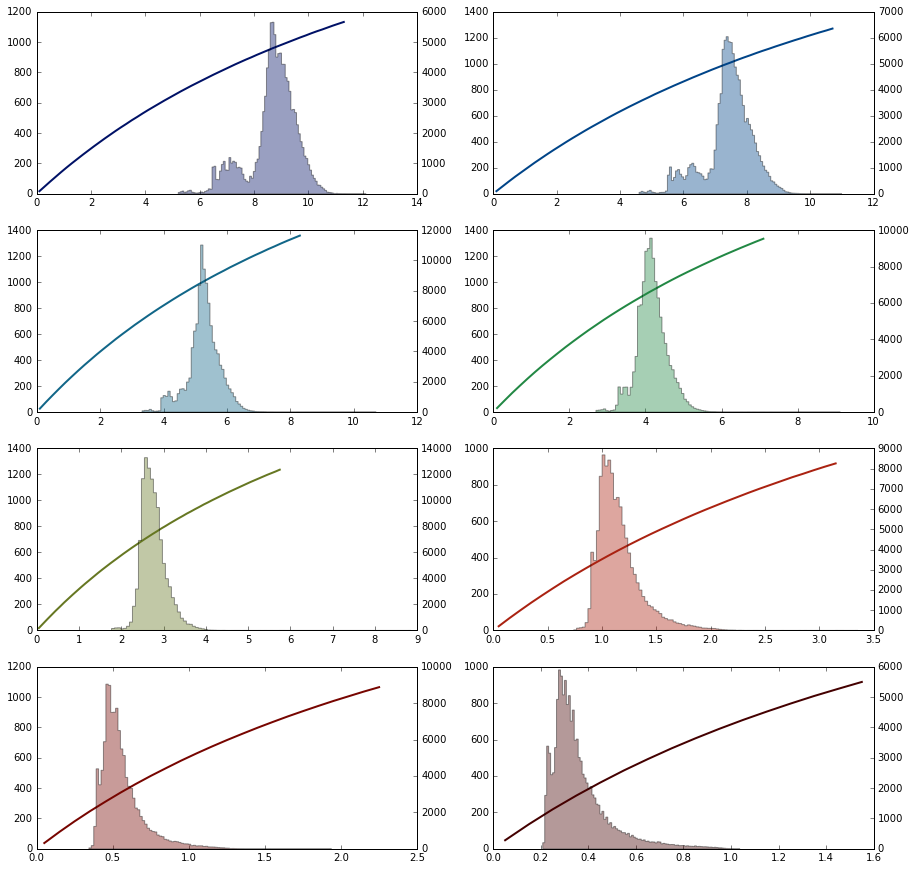

In [44]:
#COMPARE L2 masked data (histogram, right y-axis) to 
# model's input range (line plot, left y-axis). Seems fine
fig,axs = plt.subplots(nrows=4,ncols=2,figsize=(15,15))
colDict = {'412':'#001166','443':'#004488','490':'#116688',
           '510':'#228844','555':'#667722','670':'#aa2211',
           '765':'#770500','865':'#440000'}
axs2=np.empty_like(axs)
reshBands = np.reshape(bands,(4,2))
for i in range(4):
    for j in range(2):
        axs2[i,j] = axs[i,j].twinx()
        band = reshBands[i,j]
        datatemp = np.ma.array(swfLtDict[band],mask=l2MaskArr)
        data = datatemp.compressed()/10 # convert 
        axs[i,j].plot(ltdict[band],snrdict[band],color=colDict[band],label=band,lw=2,fontsize=14)
        axs2[i,j].hist(data,bins=100,histtype="stepfilled",alpha=0.4,color=colDict[band])
        axs[i,j].legend(loc='best')
        

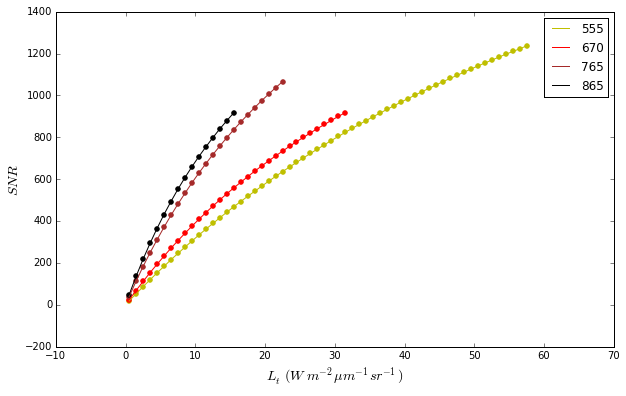

In [49]:
#
fig,ax3=plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(10)
plt.plot(lt_555,snr_555,color='y',label='555')
plt.scatter(lt_555,y5555,color='y')
plt.plot(lt_670,snr_670,color='r',label='670')
plt.scatter(lt_670,y6705,color='r')
plt.plot(lt_765,snr_765,color='brown',label='765')
plt.scatter(lt_765,y7655,color='brown')
plt.plot(lt_865,snr_865,color='k',label='865')
plt.scatter(lt_865,y8655,color='k')
plt.ylabel(r'$SNR$',fontsize=14)
plt.xlabel(r'$L_t \ (W \ m^{-2}\mu m^{-1} sr^{-1})$',fontsize=14)
plt.legend(loc='best');

In [167]:
# now to compute weighted average of sigma for each band
def ComputeWeightedAverage(data):
    
    cnts,edges = np.histogram(data,bins=binsize)
    bin_middles = (edges[:1] + edges[1:]) / 2
    wts = np.array(range(len(cnts))) / sum(range(len(cnts)))
    wtdAvg = np.average(bin_middles,weights=wts)
    return wtdAvg

In [193]:
wtdAvg412 = ComputeWeightedAverage(std_N_412)
wtdAvg443 = ComputeWeightedAverage(std_N_443)
wtdAvg490 = ComputeWeightedAverage(std_N_490)
wtdAvg510 = ComputeWeightedAverage(std_N_510)
wtdAvg555 = ComputeWeightedAverage(std_N_555)
wtdAvg670 = ComputeWeightedAverage(std_N_670)
wtdAvg765 = ComputeWeightedAverage(std_N_765)
wtdAvg865 = ComputeWeightedAverage(std_N_865)


In [192]:
print avg412,wtdAvg412
print avg443,wtdAvg443
print avg490,wtdAvg490
print avg510,wtdAvg510
print avg555,wtdAvg555
print avg670,wtdAvg670
print avg765,wtdAvg765
print avg865,wtdAvg865

0.0983333884104 0.111869394315
0.0910810086348 0.102028224764
0.0894785288607 0.0995285073763
0.0936985527006 0.102540670852
0.109930732595 0.119191754296
0.173823022692 0.179139579344
0.198926750903 0.207862049713
0.261063183692 0.287543156691
